# Customer Behaviour Insight Engine - Product Associations (Notebook 5)


This notebook explores which products are frequently bought together.

We use two approaches:

1. A simple, transparent Pandas-based analysis of product pairs per order  
2. A formal association rule mining approach (Apriori) using `mlxtend`

These methods are commonly used for:
- “Frequently bought together” recommendations  
- Product bundling and cross-sell opportunities  
- Understanding how customers combine products in a single order

In [6]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

# Load cleaned tables
orders = pd.read_csv(processed_path + "orders_clean.csv", parse_dates=["order_time"])
order_items = pd.read_csv(processed_path + "order_items_clean.csv")
products = pd.read_csv(processed_path + "products_clean.csv")

print("orders:", orders.shape)
print("order_items:", order_items.shape)
print("products:", products.shape)

orders.head()

orders: (33580, 10)
order_items: (59163, 5)
products: (1197, 6)


,order_id,customer_id,order_time,payment_method,discount_pct,subtotal_usd,total_usd,country,device,source
0,1,13917,2025-01-31 23:07:42,card,20,107.15,85.72,PL,desktop,organic
1,2,1022,2024-02-19 01:17:50,card,0,116.17,116.17,FR,tablet,organic
2,3,6145,2024-12-04 20:24:13,card,0,137.35,137.35,US,mobile,organic
3,4,3152,2024-07-17 08:50:47,card,15,32.18,27.35,BR,mobile,email
4,5,12378,2020-08-21 16:54:16,card,0,238.09,238.09,NL,desktop,paid


## 1. Build product baskets per order 

Group order items by `order_id` so each row represents one order and contains a list of product_ids bought together. 

In [8]:
#Keep only oders with valid product_id
order_items = order_items.dropna(subset=["product_id"])

#cast product_id to int
order_items["product_id"] = order_items["product_id"].astype(int)

# Group by order and collect products into a list 
baskets= (
    order_items
    .groupby("order_id")["product_id"]
    .apply(list)
    .reset_index(name="products")

)

baskets.head(10)

,order_id,products
0,1,[226]
1,2,[771]
2,3,"[415, 24]"
3,4,[1157]
4,5,"[846, 745]"
5,6,"[123, 888]"
6,7,"[405, 487, 442, 348]"
7,8,[949]
8,9,"[613, 755, 1078]"
9,10,[769]


## 2. Single-product frequencies (support)

Compute how many orders contain each product and the support (share of orders).

In [54]:
# Total number of orders
n_orders = len(baskets)
print("Total orders:", n_orders)

# Explode lists so each row is one (order_id, product_id)
exploded = baskets.explode("products").rename(columns={"products": "product_id"})

# Count distinct orders each product appears in
product_counts = (
    exploded.groupby("product_id")["order_id"]
    .nunique()
    .reset_index(name="order_count")
)

# Compute support measure
product_counts["support"] = product_counts["order_count"] / n_orders

product_counts.head()

Total orders: 33580


,product_id,order_count,support
0,1,2,0.000060
1,2,2,0.000060
2,3,4,0.000119
3,4,14,0.000417
4,5,44,0.001310


## 3. Product pair co-concurrence with Pandas 

For each order, generate all unique ordered product pairs and count how many orders each pair appers in. 

In [15]:
from itertools import combinations
from collections import Counter

pair_counter = Counter()

for products_list in baskets["products"]:
    unique_products = sorted(set(products_list))
    for combo in combinations(unique_products, 2):
        pair_counter[combo] += 1

pair_df = (
    pd.DataFrame(
        [(a, b, count) for (a, b), count in pair_counter.items()],
        columns=["product_a", "product_b", "pair_count"]
    )
)

pair_df.head()

,product_a,product_b,pair_count
0,24,415,1
1,745,846,1
2,123,888,1
3,348,405,1
4,348,442,1


## 4. Rule metrics: support, confidence lift (Pandas)

Using the pair counts and single-product supports, compute classic association rule metrics for A -> B

In [17]:
# Merge product supports onto pairs
pair_with_support = (
    pair_df
    .merge(
        product_counts[["product_id", "support"]].rename(
            columns={"product_id": "product_a", "support": "support_a"}
        ),
        on="product_a",
        how="left"
    )
    .merge(
        product_counts[["product_id", "support"]].rename(
            columns={"product_id": "product_b", "support": "support_b"}
        ),
        on="product_b",
        how="left"
    )
)

pair_with_support["support_ab"] = pair_with_support["pair_count"] / n_orders

# Avoid division by zero
pair_with_support = pair_with_support[
    (pair_with_support["support_a"] > 0) &
    (pair_with_support["support_b"] > 0)
]

# Confidence and lift for rule A → B
pair_with_support["confidence_A_to_B"] = (
    pair_with_support["support_ab"] / pair_with_support["support_a"]
)

pair_with_support["lift_A_to_B"] = (
    pair_with_support["support_ab"] /
    (pair_with_support["support_a"] * pair_with_support["support_b"])
)

pair_with_support.head()

,product_a,product_b,pair_count,support_a,support_b,support_ab,confidence_A_to_B,lift_A_to_B
0,24,415,1,0.002561,0.001429,0.00003,0.011628,8.134690
1,745,846,1,0.000566,0.002412,0.00003,0.052632,21.819363
2,123,888,1,0.001846,0.001668,0.00003,0.016129,9.671659
3,348,405,1,0.000864,0.002740,0.00003,0.034483,12.586207
4,348,442,1,0.000864,0.003693,0.00003,0.034483,9.338154


In [19]:
rules_pandas = (
    pair_with_support
    .query("support_ab >= 0.01 and confidence_A_to_B >= 0.3 and lift_A_to_B >= 1.0")
    .sort_values("lift_A_to_B", ascending=False)
)

rules_pandas.head(10)

,product_a,product_b,pair_count,support_a,support_b,support_ab,confidence_A_to_B,lift_A_to_B


In [23]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 44.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mlxtend]m4/5 [mlxtend]earn]


## 5. Apriori-based association rules (mlextend)

Build a one-hot encoded order-product matrix and run the Apriori algorithm to find frequent itemsets and association rules with support, conficence and lift. 

In [28]:
from mlxtend.frequent_patterns import apriori, association_rules

# Re-use 'exploded' from before (order_id, products)
basket_matrix = (
    exploded
    .assign(value=True)
    .pivot_table(
        index="order_id",
        columns="product_id",
        values="value",
        aggfunc="max",
        fill_value=False
    )
)

basket_matrix.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
frequent_itemsets = apriori(
    basket_matrix,
    min_support=0.002,
    use_colnames=True,
    max_len=2
)

frequent_itemsets.sort_values("support", ascending=False).head(10)

,support,itemsets
91,0.004139,(496)
72,0.003663,(442)
60,0.003633,(404)
166,0.003395,(861)
57,0.003365,(392)
45,0.003306,(358)
146,0.003306,(769)
48,0.003306,(366)
94,0.003306,(504)
308,0.003306,(1148)


## Why Apriori Returned only Single-Item Itemsets 

In this dataset, most orders contain one product (median =1; only a small fraction have more than one item).
Apriori detects product pairs or sets if:

1. They appear together in the same order 
2. They repeat accross many orders 

Because basket sizes are small and combinations rarely repeat, Apriori correctly identifies no sufficiently frequent pairs. 
This is a realistic outcome in e-commerce data. 
To uncover meaningful product relationships, a pivot to session-based affinity analyiss will be made. This captures how products co-occur in browing behaviour, not only in final purchaes. 

In [37]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

# Load events_clean
events = pd.read_csv(
    processed_path + "events_clean.csv",
    parse_dates=["timestamp"]
)

print("events:", events.shape)
events.head()

events: (760958, 10)


,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd
0,1,1,2021-12-27 00:08:36,page_view,93.0,NaN,NaN,NaN,NaN,NaN
1,2,1,2021-12-27 00:16:36,page_view,1005.0,NaN,NaN,NaN,NaN,NaN
2,3,1,2021-12-27 00:18:01,add_to_cart,1005.0,1.0,NaN,NaN,NaN,NaN
3,4,1,2021-12-27 00:45:36,page_view,918.0,NaN,NaN,NaN,NaN,NaN
4,5,1,2021-12-27 01:03:36,page_view,946.0,NaN,NaN,NaN,NaN,NaN


In [41]:
# --- 5B: Session-based product co-view matrix ---
## Which products tend to be seen in the same sesion?

# Filter to page views only
views = events[events["event_type"] == "page_view"]

# Group views by session and list product_ids
session_product_views = (
    views.groupby("session_id")["product_id"]
    .apply(lambda x: list(x.dropna().astype(int)))
    .reset_index(name="products_viewed")
)

session_product_views.head()

,session_id,products_viewed
0,1,"[93, 1005, 918, 946, 915, 931, 978]"
1,2,"[929, 226, 864, 1151, 855]"
2,3,"[771, 743]"
3,4,"[1043, 918]"
4,5,"[273, 832, 591, 635, 398, 892]"


In [40]:
from collections import Counter
import itertools

pair_counts = Counter()

for products in session_product_views["products_viewed"]:
    unique_products = set(products)
    for a, b in itertools.combinations(sorted(unique_products), 2):
        pair_counts[(a, b)] += 1

# Convert to DataFrame
pair_df = (
    pd.DataFrame(
        [(a, b, count) for (a, b), count in pair_counts.items()],
        columns=["product_A", "product_B", "co_views"]
    )
    .sort_values("co_views", ascending=False)
)

pair_df.head(10)

,product_A,product_B,co_views
35117,288,300,25
2993,429,461,24
86084,670,671,23
85774,1029,1049,22
15959,541,678,22
26893,1137,1180,22
35511,404,442,21
74807,1101,1186,21
72782,358,377,21
25806,231,271,21


In [42]:
# Product view counts 
product_view_counts = views["product_id"].value_counts().to_dict()

pair_df["support_A"] = pair_df["product_A"].map(product_view_counts)
pair_df["support_B"] = pair_df["product_B"].map(product_view_counts)

pair_df["affinity"] = pair_df["co_views"] / pair_df[["support_A", "support_B"]].min(axis=1)

pair_df.sort_values("affinity", ascending=False).head(10)

,product_A,product_B,co_views,support_A,support_B,affinity
45419,10,135,17,528,302,0.056291
67431,601,672,15,595,272,0.055147
76442,27,64,13,573,245,0.053061
118029,38,82,11,628,208,0.052885
96620,21,55,11,209,574,0.052632
117354,55,58,12,574,230,0.052174
25708,58,121,12,230,667,0.052174
219731,12,101,11,214,608,0.051402
43849,14,48,14,581,277,0.050542
107591,27,88,11,573,221,0.049774


In [ ]:
I 

## Co-occurence Heatmap 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

orders = pd.read_csv(processed_path + "orders_clean.csv")
order_items = pd.read_csv(processed_path + "order_items_clean.csv")

# Build baskets: one list of product_ids per order
baskets = (
    order_items
    .groupby("order_id")["product_id"]
    .apply(lambda x: list(x.dropna().astype(int)))
    .reset_index(name="products")
)

# Total number of orders
n_orders = len(baskets)
print("Total orders:", n_orders)

# Explode to one row per (order_id, product_id)
exploded = baskets.explode("products")  # column is still called "products"

# Count orders per product and support
product_counts = (
    exploded["products"]
    .value_counts()
    .reset_index(name="order_count")
    .rename(columns={"index": "product_id"})
)

product_counts["support"] = product_counts["order_count"] / n_orders
product_counts.head()

Total orders: 33580


,products,order_count,support
0,496,139,0.004139
1,442,124,0.003693
2,404,122,0.003633
3,861,115,0.003425
4,392,113,0.003365


In [55]:
# ---- Build a co-purchase matrix for the top N products ----

top_n = 20  # you can change this to 15, 25, etc.

top_products = (
    product_counts
    .sort_values("support", ascending=False)
    .head(top_n)["product_id"]
    .tolist()
)

# Subset the basket matrix to just those products
subset = basket_matrix[top_products]

# Co-purchase counts: for each product pair (i, j), how many orders contain both?
co_counts = subset.T.dot(subset)

# Convert counts to support (fraction of all orders)
co_support = co_counts / n_orders

co_support

product_id,496,442,404,861,392,504,769,366,358,1148,944,265,1087,869,669,741,485,891,926,231
product_id,,,,,,,,,,,,,,,,,,,,
496,0.00003,0.00000,0.00003,0.00003,0.00000,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000
442,0.00000,0.00003,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000
404,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00000,0.00003,0.00000
861,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00000
392,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00003,0.00003,0.00003,0.00000,0.00003,0.00000
504,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00003,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000
769,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
366,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00003,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000
358,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00003,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000


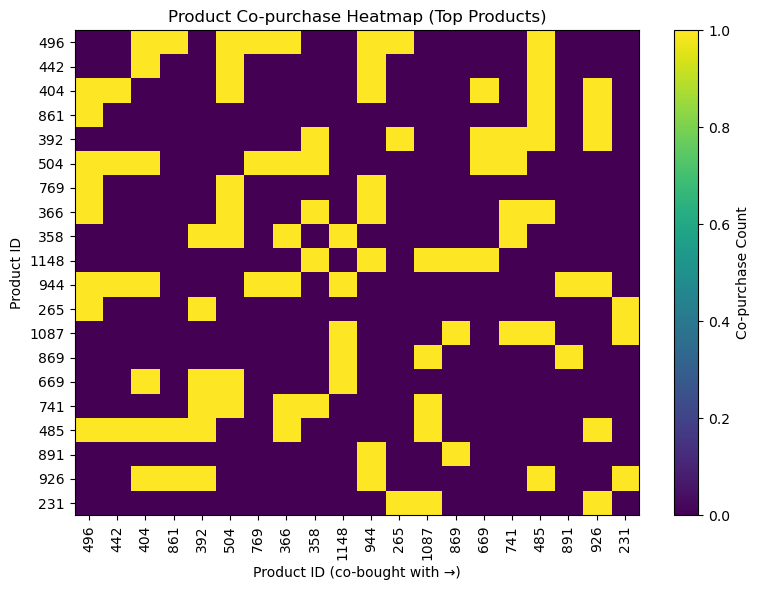

In [63]:
# ---- Plot the co-purchase heatmap ----

# Co-purchase counts matrix
co_counts = subset.T.dot(subset)

# Zero out the diagonal (product with itself)
np.fill_diagonal(co_counts.values, 0)

plt.figure(figsize=(8, 6))

np.fill_diagonal(co_counts.values, 0)

plt.imshow(co_counts, aspect="auto", cmap="viridis")
plt.colorbar(label="Co-purchase Count")

plt.xticks(range(len(top_products)), top_products, rotation=90)
plt.yticks(range(len(top_products)), top_products)

plt.title("Product Co-purchase Heatmap (Top Products)")
plt.xlabel("Product ID (co-bought with →)")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()

# 6. Session-based co-view heatmap